### 🕵️‍♂️ Check‑worthy Claim Detection

The **Check‑worthy Claim Detection** tool flags sentences that deserve human fact‑checking, statements that could misinform the public or have real‑world impact. It helps analysts sift massive news streams and focus on the most important claims.

| Key feature | Description |
|-------------|-------------|
| **Label**   | `1` = check‑worthy, `0` = not |
| **Score**   | Confidence from 0 to 1 |
| **Granularity** | Whole text **and** per‑segment spans |
| **Languages**  | English, Spanish, Italian |
| **Model**   | Transformer (BERT/Roberta family) with multi‑task fine‑tuning on factuality signals |




In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1 ▸ Dependencies (Polars, Matplotlib, Trino client)
# ─────────────────────────────────────────────────────────────────────────────
%pip install -qU "trino[sqlalchemy]==0.332.0" "polars>=0.19" matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 2 ▸ Imports and helper functions
# ─────────────────────────────────────────────────────────────────────────────
import os, re, json, datetime as dt
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from trino.dbapi import connect

plt.rcParams["figure.dpi"] = 110  # High-resolution plots for clarity
plt.rcParams.update({"axes.grid": False, "figure.facecolor": "white", "axes.facecolor": "white"})

# JSON serialization helpers
def _json_default(v):
    if isinstance(v, (dt.datetime, dt.date)):
        return v.isoformat()
    return repr(v)

def save_dict(d: dict, path: Path):
    """Save a dictionary as JSON to the given path (with date handling)."""
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    """Load JSON data from a file into a Python dictionary."""
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    """Recreate a Polars DataFrame from stored JSON data."""
    df = pl.DataFrame(data_d)
    # Convert publish_date strings back to date type if necessary
    if "publish_date" in df.columns and df["publish_date"].dtype == pl.Utf8:
        df = df.with_columns(pl.col("publish_date").str.to_datetime(strict=False).dt.date())
    return df

# Host/port parser (with default port and validation)
def _parse_host_port(host: str, port: str, default_port: int = 8080):
    host = (host or "").strip()
    port = (port or "").strip()
    # Strip protocol from host if present
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 3 ▸ Parameters (date range, etc.)
# ─────────────────────────────────────────────────────────────────────────────
LIMIT      = None  # Optional: limit number of rows for testing
START_DATE = "2025-03-01"
END_DATE   = "2025-07-27"
JSON_PATH  = Path("news_tool_checkworthy_claim_detection_daily_positive_counts.json")


In [ ]:


# ─────────────────────────────────────────────────────────────────────────────
# 4 ▸ Connect to Trino
# ─────────────────────────────────────────────────────────────────────────────
TRINO_HOST, TRINO_PORT = _parse_host_port(os.getenv("TRINO_HOST"), os.getenv("TRINO_PORT"))
TRINO_USER    = os.getenv("TRINO_USER", "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
# print(f"🔌 Connecting to Trino at {TRINO_HOST}:{TRINO_PORT}, catalog='{TRINO_CATALOG}'")

conn = connect(host=TRINO_HOST, port=TRINO_PORT, user=TRINO_USER, catalog=TRINO_CATALOG)
cur  = conn.cursor()


In [ ]:

# ─────────────────────────────────────────────────────────────────────────────
# 5 ▸ Run query (with date parsing, filtering, and deduplication by URL)
# ─────────────────────────────────────────────────────────────────────────────
# Prepare date parsing for created_at (to handle ISO8601 or '%Y-%m-%d %H:%i:%s' formats)
parse_created = (
    "COALESCE("
    "  CAST(TRY(from_iso8601_timestamp(cn.created_at)) AS timestamp), "
    "  TRY(date_parse(cn.created_at, '%Y-%m-%d %H:%i:%s'))"
    ")"
)
# Build WHERE clauses for date filtering
where_clauses = ["(cn.publish_date IS NOT NULL OR cn.created_at IS NOT NULL)"]
if START_DATE:
    where_clauses.append(
        f"""COALESCE(
                date(from_iso8601_timestamp(cn.publish_date)),
                date({parse_created})
            ) >= DATE '{START_DATE}'"""
    )
if END_DATE:
    where_clauses.append(
        f"""COALESCE(
                date(from_iso8601_timestamp(cn.publish_date)),
                date({parse_created})
            ) <= DATE '{END_DATE}'"""
    )
cn_where = " AND ".join(where_clauses)

query = f"""
WITH staged AS (
    SELECT
        cn.id                             AS id_collected_news,
        cn.url                            AS url,
        cn.publish_date                   AS publish_date,
        cn.title                          AS title_collected_news,
        cn.text                           AS text,
        tccd.title                        AS title_checkworthy_claim_detection,  -- ROW(score, label)
        tccd.body                         AS body_checkworthy_claim_detection,   -- ROW(score, label)
        tccd.created_at                   AS created_at_tccd,
        {parse_created}                   AS created_ts
    FROM news.collected_news AS cn
    JOIN tools.text_checkworthy_claim_detection AS tccd
      ON cn.id = tccd.content_id
    WHERE {cn_where}
),
dedup AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY url ORDER BY created_ts) AS rn
    FROM staged
)
SELECT
    COALESCE(date(from_iso8601_timestamp(publish_date)), date(created_ts)) AS publish_date,
    id_collected_news,
    title_collected_news,
    text,
    title_checkworthy_claim_detection,
    body_checkworthy_claim_detection,
    created_at_tccd
FROM dedup
WHERE rn = 1
"""
if LIMIT is not None:
    query += f"\nLIMIT {LIMIT}"

# print("⏳ Executing query…")
try:
    cur.execute(query)
    rows    = cur.fetchall()
    columns = [c[0] for c in cur.description]  # e.g., ["publish_date", "id_collected_news", ...]
finally:
    cur.close()
    conn.close()
# if not rows:
#     raise ValueError("No data found.")
# print(f"✅ Retrieved {len(rows):,} rows")


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 6 ▸ Build Polars DataFrame & parse score/label fields
# ─────────────────────────────────────────────────────────────────────────────
assert rows is not None and len(columns) > 0, "No data retrieved from query."
data_dict = {col: [row[i] for row in rows] for i, col in enumerate(columns)}

# Polars may infer mixed types for nested fields (score/label as tuples), so ensure Object type
for col in ("title_checkworthy_claim_detection", "body_checkworthy_claim_detection"):
    data_dict[col] = pl.Series(col, data_dict[col], dtype=pl.Object)

df = pl.DataFrame(data_dict, strict=False)

# Parse the ROW(...) structures into separate score and label columns
def _parse_row(v):
    """Convert a ROW(score, label) value into a (score, label) tuple."""
    if v is None:
        return (None, None)
    if isinstance(v, dict):
        return (v.get("score"), v.get("label"))
    if isinstance(v, tuple) and len(v) == 2:
        return v
    # Fallback: regex parse from string
    m = re.match(r"\(?\s*(?:score\s*:\s*)?([0-9.+\-eE]+)\s*,\s*(?:label\s*:\s*)?([0-9]+)\s*\)?", str(v))
    return (float(m.group(1)), int(m.group(2))) if m else (None, None)

df = df.with_columns([
    pl.Series("score_title", [p[0] for p in map(_parse_row, df["title_checkworthy_claim_detection"])]),
    pl.Series("label_title", [p[1] for p in map(_parse_row, df["title_checkworthy_claim_detection"])]),
    pl.Series("score_body",  [p[0] for p in map(_parse_row, df["body_checkworthy_claim_detection"])]),
    pl.Series("label_body",  [p[1] for p in map(_parse_row, df["body_checkworthy_claim_detection"])]),
])

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 7-9 ▸ Data cleaning, filtering, deduplication, aggregation, and JSON generation
# ─────────────────────────────────────────────────────────────────────────────
# Ensure publish_date is of date type and filter out invalid or out-of-range dates
df = df.with_columns(pl.col("publish_date").cast(pl.Date)).filter(pl.col("publish_date").is_not_null())
# Remove any records prior to 2025
df = df.filter(pl.col("publish_date") >= dt.date(2025, 1, 1))
# Apply date range filtering (within START_DATE to END_DATE)
if START_DATE:
    df = df.filter(pl.col("publish_date") >= dt.date.fromisoformat(START_DATE))
if END_DATE:
    df = df.filter(pl.col("publish_date") <= dt.date.fromisoformat(END_DATE))
# (Deduplication by URL was already handled in the SQL query using ROW_NUMBER)
# print(f"After date filter: {df.height:,} rows")

# Aggregate daily counts of positive labels for title and body
daily = (df.group_by("publish_date")
           .agg([
               (pl.col("label_body")  == 1).sum().alias("body_positive"),
               (pl.col("label_title") == 1).sum().alias("title_positive")
           ])
           .sort("publish_date"))

# print(daily.head().fetch())  # debug: view a few rows (commented out)

# Prepare metadata for plotting and save to JSON
plot_meta = {
    "data"      : daily.to_dict(as_series=False),
    "title"     : "Daily count of positive body and title detections",
    "labels"    : ["Body positive (label = 1)", "Title positive (label = 1)"],
    "color_map" : {"body_positive": "seagreen", "title_positive": "lightblue"},
    "chart_type": "grouped_bar",
    "platform"  : "News"
}
save_dict(plot_meta, JSON_PATH)
# print(f"💾 Saved JSON → {JSON_PATH.resolve()}")


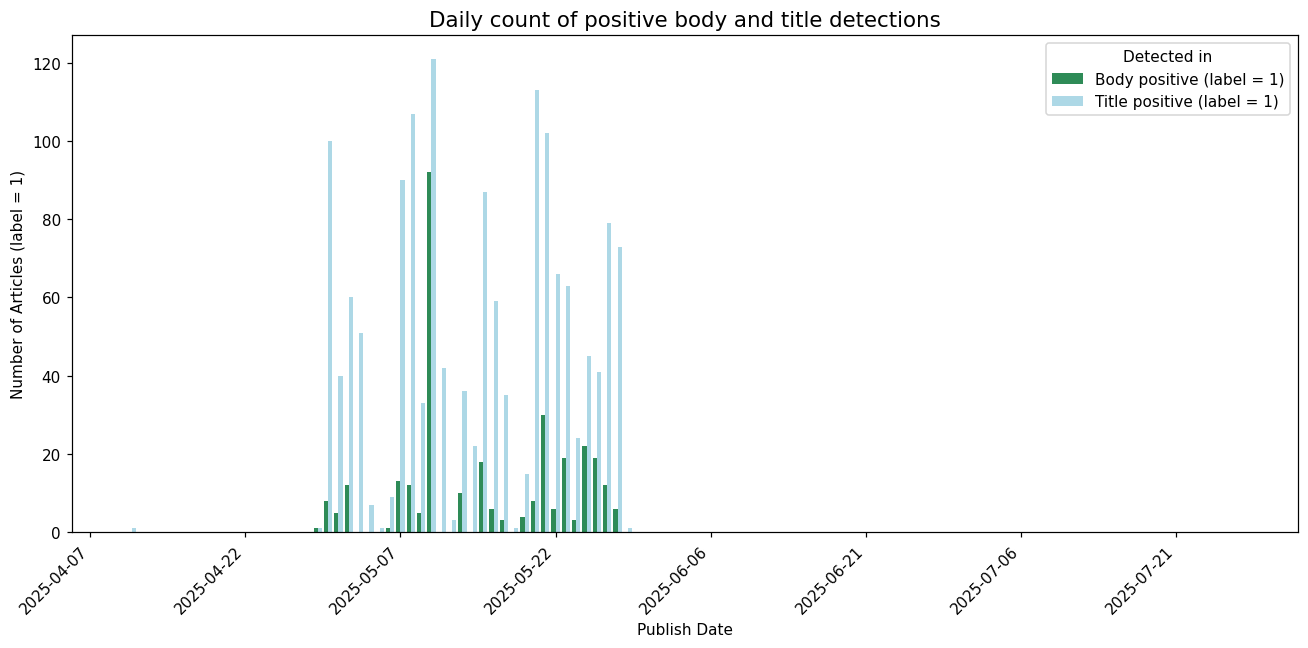

In [ ]:


# ─────────────────────────────────────────────────────────────────────────────
# 10 ▸ Reload JSON & Plot visualization
# ─────────────────────────────────────────────────────────────────────────────
meta    = load_dict(JSON_PATH)
df_plot = df_from_data_d(meta["data"])

dates   = df_plot["publish_date"].to_list()
body    = df_plot["body_positive"].to_list()
title   = df_plot["title_positive"].to_list()
x_dates = mdates.date2num([dt.datetime(d.year, d.month, d.day) for d in dates])

fig, ax = plt.subplots(figsize=(12, 6))
bar_w = 0.4  # width of each bar

ax.bar(x_dates - bar_w/2, body,  width=bar_w, color=meta["color_map"]["body_positive"],  label=meta["labels"][0])
ax.bar(x_dates + bar_w/2, title, width=bar_w, color=meta["color_map"]["title_positive"], label=meta["labels"][1])

ax.set_xlabel("Publish Date")
ax.set_ylabel("Number of Articles (label = 1)")
ax.set_title(meta["title"], fontsize=14)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="Detected in")
plt.tight_layout()
plt.show()